## **Step 1: Importing dependencies**

In [1]:
import numpy as np
import re
import pandas as pd
from bs4 import BeautifulSoup
import csv

import matplotlib.pyplot as plt
# from google.colab import drive, files

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers
import tqdm as notebook_tqdm

import tensorflow_datasets as tfds
print(tf.test.gpu_device_name())


/home/ficast/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/device:GPU:0


2022-07-24 12:17:04.772684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 12:17:05.431152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 5667 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## **Step 2: Data preprocessing**

### Loading data


In [3]:
# Just required for run it in google colab
# drive.mount('/content/drive')

In [4]:
cols= ["text"]
# path = "/content/drive/MyDrive/projeto/Projeto II - BDI Uniasselvi/Dataset AMAZON/amazon_train.ft.txt"
path = "./amazon.ft.txt"

f = open(path, encoding="latin")

data = []
for line in f:
    data_line = [line[9], line[11:]]
    data.append(data_line)

In [5]:
df = pd.DataFrame(data, columns=['label', 'text'])
df.head(7)


,label,text
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...
5,1,DVD Player crapped out after one year: I also ...
6,1,"Incorrect Disc: I love the style of this, but ..."


### Cleaning and preparing

In [6]:
df['label'] = np.where(df['label'] == "2", 1, 0)
df = df[['text', 'label']]
df.head(7)

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1
5,DVD Player crapped out after one year: I also ...,0
6,"Incorrect Disc: I love the style of this, but ...",0


In [7]:
data_labels = df.label.values
set(data_labels)

{0, 1}

In [8]:
def clean(text):
  # text = BeautifulSoup(text).get_text()
  text = re.sub(r"@[A-Za-z0-9]+", " ", text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", " ", text)
  text = re.sub(r"[^A-Za-z0-9]", " ", text)
  text = re.sub(r" +", " ", text)
  return text

In [9]:
data_clean = [clean(line) for line in df.text]

In [10]:
data_clean[1093]

'Great Read Suspenseful When I first started reading the book I kept putting it down it just wasn t grabbing my attention but once I got further into the book my curiosity got the best of me I couldn t put the book down I could not believe that a woman would do the things that she did Adrian Jenkins was confused and deceitful All hell does break loose Gregory s relationship with his mother was sad I understand her point for leaving but at the same time it was selfish It not only destroyed Gregory but it also destroyed his little sister I am definately looking forward to her next book '

### Tokenizing

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
num_words = 100000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [13]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(data_clean)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(data_clean)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
print(maxlen)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

249


### Split train / test

In [14]:
size = len(train_padded)
test_idx = np.random.randint(0, size, round(size/10))

In [15]:
test_inputs = train_padded[test_idx]
test_labels = data_labels[test_idx]

In [16]:
train_inputs = np.delete(train_padded, test_idx, axis=0)

In [17]:
train_labels = np.delete(data_labels, test_idx)

## **Step 3: Building the Model**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, GlobalMaxPool1D, Embedding, Dropout

# params
vocab_size=num_words
emb_dim=200
nb_filters=100
FFN_units=256
nb_classes=len(set(train_labels))
dropout_rate=0.2

# create model
model = Sequential()

model.add(Embedding(vocab_size, emb_dim))

model.add(Conv1D(filters=nb_filters,
                         kernel_size=2,
                         padding="valid",
                         activation="relu"))
    
model.add(GlobalMaxPool1D())

model.add(Dense(units=FFN_units, activation="relu"))

model.add(Dropout(rate=dropout_rate))

if nb_classes == 2:
    model.add(Dense(units=1, activation="sigmoid"))
else:
    model.add(Dense(units=nb_classes, activation="softmax"))



2022-07-24 12:19:20.215469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5667 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## **Stpe 4: Training Model**

### Train

In [19]:
if nb_classes == 2:
    model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
else:
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["sparse_categorical_accuracy"])

In [20]:
checkpoint_path = "/checkpoint"
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint looaded from {}".format(ckpt_manager.latest_checkpoint))

In [21]:
#params
BATCH_SIZE = 32
NB_EPOCHS = 10

history = model.fit(train_inputs,
                    train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=NB_EPOCHS)


2022-07-24 12:19:20.339957: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1305569748 exceeds 10% of free system memory.


Epoch 1/10


2022-07-24 12:19:22.480061: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-07-24 12:19:23.438523: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-24 12:19:24.623205: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40963/40963 [==============================] - 604s 15ms/step - loss: 0.2019 - accuracy: 0.9205
Epoch 2/10
40963/40963 [==============================] - 694s 17ms/step - loss: 0.1570 - accuracy: 0.9420
Epoch 3/10
40963/40963 [==============================] - 653s 16ms/step - loss: 0.1299 - accuracy: 0.9539
Epoch 4/10
40963/40963 [==============================] - 638s 16ms/step - loss: 0.1054 - accuracy: 0.9638
Epoch 5/10
40963/40963 [==============================] - 633s 15ms/step - loss: 0.0831 - accuracy: 0.9723
Epoch 6/10
40963/40963 [==============================] - 634s 15ms/step - loss: 0.0647 - accuracy: 0.9789
Epoch 7/10
40963/40963 [==============================] - 636s 16ms/step - loss: 0.0502 - accuracy: 0.9840
Epoch 8/10
40963/40963 [==============================] - 637s 16ms/step - loss: 0.0387 - accuracy: 0.9878
Epoch 9/10
40963/40963 [==============================] - 647s 16ms/step - loss: 0.0302 - accuracy: 0.9905
Epoch 10/10
40963/40963 [=======================

### Visualize Model

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         20000000  
                                                                 
 conv1d (Conv1D)             (None, None, 100)         40100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

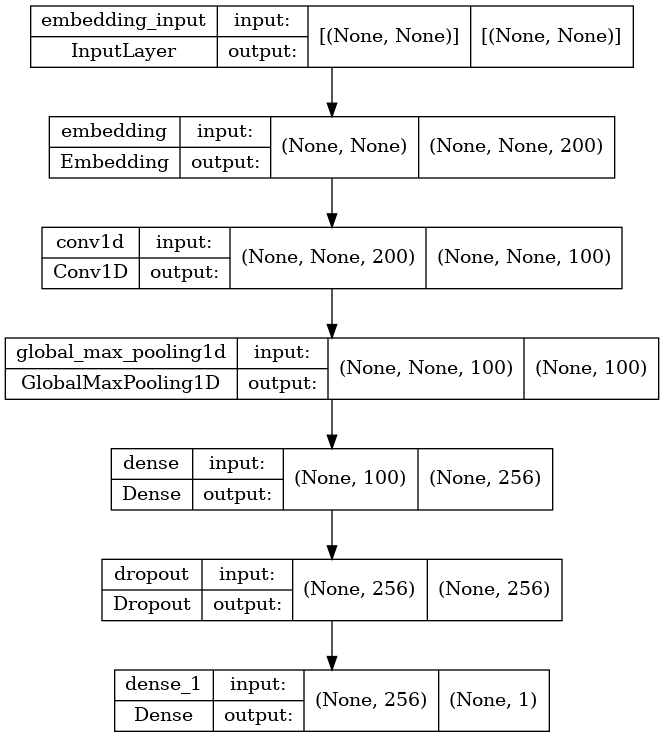

In [23]:
tf.keras.utils.plot_model(model, to_file="assets/model_plot.png", show_shapes=True)

## **Step 5: Model evaluation**

In [47]:
test_loss, test_acc = model.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE, verbose=2)

4527/4527 - 4s - loss: 0.3360 - accuracy: 0.9175 - 4s/epoch - 902us/step


In [49]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
print(test_acc)

0.9174709320068359


In [45]:
def predict(list_of_sequences):
    sentences = tokenizer.texts_to_sequences(list_of_sequences)
    predict_padded = pad_sequences(sentences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
    print(predict_padded)
    for i in model.predict(predict_padded):
        print([i, "Positive" if i > 0.5 else "Negative"])

In [37]:
predict(["I love this", 
         "I can buy a new one of this every year", 
         "Definitely a good choice",
         "I wanna more this is awesome I would like to have bought it earlier",
         ])


[[3, 79, 9], [3, 42, 88, 5, 107, 27, 8, 9, 159, 184], [346, 5, 35, 938], [3, 2250, 51, 9, 10, 402, 3, 45, 33, 6, 23, 109, 7, 1110]]
[array([0.9570017], dtype=float32), 'Positive']
[array([0.6624592], dtype=float32), 'Positive']
[array([0.9999579], dtype=float32), 'Positive']
[array([0.9716833], dtype=float32), 'Positive']


In [38]:
predict(["I dont like this book, seems very silly", 
         "I cant recommend this brand again",
         "Not sure if this is a good choice for you, for me its absolutely useless",
         "This? Just for my haters. Its impossible to make this works. I guess its the worst game Ive bought in my life"
         ])

[[3, 521, 33, 9, 22, 269, 36, 1193], [3, 1297, 146, 9, 665, 150], [17, 240, 31, 9, 10, 5, 35, 938, 12, 14, 12, 47, 120, 444, 787], [9, 38, 12, 24, 9581, 120, 1017, 6, 123, 9, 202, 3, 487, 120, 2, 279, 169, 2187, 109, 11, 24, 149]]
[array([0.00303382], dtype=float32), 'Negative']
[array([0.00012697], dtype=float32), 'Negative']
[array([0.00752919], dtype=float32), 'Negative']
[array([0.93913686], dtype=float32), 'Positive']


### Save model

In [39]:
model.save("amazon_nlp", save_format='tf')

INFO:tensorflow:Assets written to: amazon_nlp/assets


In [40]:
comment = clean('Dove sensitive skin bar soap was recommended by my dermatologist as the most hypoallergenic soap available. Previously, I had been using another brand touting that it was "so pure it floats". The doctor said that it was actually one of the harshest soaps out there - yikes!I have had nothing but good results with Dove sensitive skin. It\'s unscented & effective, but doesn\'t dry out my skin. Amazon almost always has the best price, especially if you do subscribe and save.')
print([comment])

['Dove sensitive skin bar soap was recommended by my dermatologist as the most hypoallergenic soap available Previously I had been using another brand touting that it was so pure it floats The doctor said that it was actually one of the harshest soaps out there yikes I have had nothing but good results with Dove sensitive skin It s unscented effective but doesn t dry out my skin Amazon almost always has the best price especially if you do subscribe and save ']


In [41]:
predict([comment])

[[7832, 2174, 1047, 1503, 2095, 15, 530, 55, 24, 18649, 25, 2, 117, 42389, 2095, 611, 2094, 3, 54, 91, 268, 153, 665, 24072, 13, 7, 15, 30, 1042, 7, 13084, 2, 1967, 278, 13, 7, 15, 245, 27, 8, 2, 43006, 14469, 43, 53, 8110, 3, 23, 54, 198, 18, 35, 1142, 20, 7832, 2174, 1047, 7, 16, 18691, 1643, 18, 170, 19, 947, 43, 24, 1047, 191, 265, 241, 49, 2, 84, 188, 352, 31, 14, 68, 7827, 4, 414]]
[array([0.9941239], dtype=float32), 'Positive']


In [42]:
comment_neg = clean("I ordered a package that was supposed to include 24 bars of soap, but only 4 arrived. $26.00 is too much money for 4 bars of soap! I called Amazon's help line but nobody ever answered, and I can't find any other recourse for getting the remaining 20 bars. I'm sure the soap is fine--I love Dove--but this order turned into an expensive error.")
predict([comment_neg])

[[3, 365, 5, 901, 13, 15, 732, 6, 1216, 1788, 2774, 8, 2095, 18, 63, 230, 643, 4572, 1197, 10, 86, 75, 124, 12, 230, 2774, 8, 2095, 3, 500, 191, 16, 297, 394, 18, 2234, 126, 4747, 4, 3, 42, 19, 142, 97, 78, 16754, 12, 295, 2, 4385, 553, 2774, 3, 95, 240, 2, 2095, 10, 327, 3, 79, 7832, 18, 9, 373, 700, 116, 41, 727, 1639]]
[array([1.7384283e-06], dtype=float32), 'Negative']


In [43]:
predict(["The product and the box are damaged and wrinkled!!!Disappointed!!!"])

[[2, 98, 4, 2, 358, 26, 1985, 4, 13858, 219]]
[array([0.4071476], dtype=float32), 'Negative']


In [46]:
predict(["I paid a premium for a new book but what arrived was dirty and had clearly been used.I paid a premium for a new book but what arrived was dirty and had clearly been used.",
                    "I am using the kindle app on my ipad to view this book. However, some of the equations are just very unattractive due to the sizing issues... I gave up and decided to go back to a physical book. It would be great if this is fixed... Other people have also voiced similar concerns back last year and it's still not fixed",
                     "I've read all of the predominant machine learning related python books and this one is by \
                        far the best one. I was excited to see the second edition of this book come out. It is packed \
                            with new information (1.5x the length of the first edition) and updated for TensorFlow 2. \
                                I have the Kindle edition and find it very helpful to highlight key points. \
                                    I look forward to receiving the print edition as well once it is released.", 
                    "The product and the box are damaged and wrinkled!!! Disappointed!!!"])

[[    3   747     5  6110    12     5   107    22    18    48   643    15
   1992     4    54   908    91   156     3   747     5  6110    12     5
    107    22    18    48   643    15  1992     4    54   908    91   156
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

In [35]:
print(maxlen)

249
